# ICELL88 Demo
This notebook runs the first demo with Wafergen ICELL88 demo run. We have three cells, Embryoning ESC and Differentiated d1 which again have two replicates d1.1 and d1.2. ICELL8 have couple of their own controls, 3T3, Pos_Ctrl, and Neg_Ctrl. However, Neg_Ctrl would be dropped at the beginning of the analysis as we do not expect anything to happen there.

This demo maps with the transcripts of `mm10`. However, we would be interested to run it through the genome mapping to have an idea of how does it behave when we map it to genes.

In [2]:
import subprocess, os, csv, signal, pysam, rpy2
import numpy as np
import matplotlib.pyplot as plt
import readline
import rpy2.robjects
from matplotlib.pyplot import *
%matplotlib inline
 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
library(Rtsne)
library(ggplot2)
library(lattice)
library(GGally)
library(genefilter)
library(knitr)

We first read the result files as input. There are two result files, the `sce-1059_mm_refseq_merged.report.csv` holds a summary report and the actual raw result file is `sce-1059_mm_refseq.genematrix_sansUMI.csv`. In this analysis reads were aligned with the transcripts. So basically, we will look at the transcripts.

For ease of analysis here I will mostly keep what Karthik is doing.

While reading the `sce-1059_mm_refseq_merged.report.csv` we will skip the first 8 lines as they were mostly describing the sample name, total reads, bad reads and so on...

In [6]:
%%R
report <- read.csv(file="sce-1059_mm_refseq_merged.report.csv",skip=8)
genematrix <- read.table(file="sce-1059_mm_refseq.genematrix_sansUMI.csv", sep=",")

In [7]:
%%R
colnames(report)

 [1] "Barcode"                      "Type"                        
 [3] "Source.Sample.Name"           "Dispense.Order"              
 [5] "X384.Well.Plate.Location"     "Chip.Row.ID"                 
 [7] "Chip.Column.ID"               "Image.ID"                    
 [9] "Barcode.Read.Pairs"           "Distinct.UMIs"               
[11] "ERCC.Read.Pairs"              "Trimmed.Read.Pairs"          
[13] "NoContam.Read.Pairs"          "Mitochondria.Alignments"     
[15] "Mitochondria.Read.Pairs"      "Total.Barcode.Alignments"    
[17] "Distinct.Genes.w..Alignments" "Distinct.Gene.UMI.Combos"    
[19] "Aligned"                      "Assigned"                    
[21] "Ambiguity"                    "Chimera"                     
[23] "Duplicate"                    "FragementLength"             
[25] "MappingQuality"               "MultiMapping"                
[27] "NoFeatures"                   "Nonjunction"                 
[29] "Secondary"                    "Unmapped"                

Above are all the report column files

In [8]:
%%R
print(paste0('genematrix dimension: ', dim(genematrix)))

[1] "genematrix dimension: 405"   "genematrix dimension: 87501"


So `genematrix` holds in total `405` cells and `87501` transcripts. Each of the row represents on cells which are encoded with the barcode of the cell. Then the column represents each of the transcript. 

In most of my analysis it is actually the other way round, where the column represents cell and row represents genes. So to make it compatible to my analysis I will transpose it. However, for the time being I would keep as it is, to run with Karthik analysis.

In [9]:
%%R
print(genematrix[1:5,1:4])

            NM_001001130.2 NM_001001144.3 NM_001001160.3 NM_001001176.2
AACCAACCAAG              0              0              1              0
AACCAACTCCG              0              0              0              0
AACCATAAGTA              0              0              0              0
AACCATCATAA              0              0              2              0
AACCATTGGCT              0              0              0              0


This is the raw read of the transcripts.

There is a `UNION` row at the end of report file. I am not sure at this stage what is it for!!! But as Karthik did, I will also get rid of it anyway.

In [8]:
%%R
#Check for and separate UNION row
if(as.character(report[dim(report)[1],1]) == 'UNION'){
  union <- report[dim(report)[1],]
  union <- droplevels(union)
  report <- report[1:((dim(report)[1]) -1),]
  report <- droplevels(report)
}

We now remove low barcodes (if any), incl. Neg Ctrls. However, here Karthik is only removing the "Neg_Ctrl". We can modify it to remove the low barcodes by looking at `Total.Barcode.Alignments` column of the report or any other column we find suitable.

In [9]:
%%R
report_sub <- report[!(report$Type %in% c("Neg_Ctrl")),]
report_sub <- droplevels(report_sub)

We now remove barcodes from `genematrix` that are not in `report_sub`

In [10]:
%%R
genematrix_orig <- genematrix
genematrix <- genematrix_orig[as.character(report_sub$Barcode),,drop=F]

We now check whether the barcodes ordering in the two files are sme

In [11]:
%%R
all(rownames(genematrix) == report_sub$Barcode)

[1] TRUE


We now do a `counts per million` normalization

In [12]:
%%R
norm_factor_cpm <- rowSums(genematrix) / 1000000
genematrix_cpm <- genematrix / norm_factor_cpm

We then add a psuedocount and do a log transform of the data

In [19]:
%%R
genematrix_cpm_log2plus1 <- log2(genematrix_cpm+1)

In [20]:
%%R
FinalPCAData <- genematrix_cpm_log2plus1
pcaPRComp <- prcomp(FinalPCAData)

We now do PCA on log-transformed data.

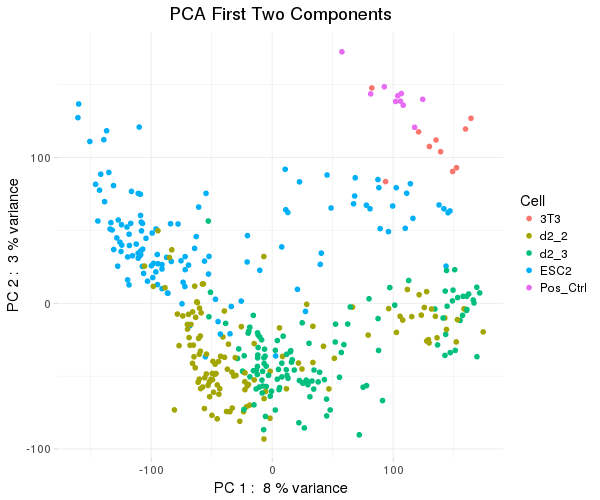

In [127]:
%%R -w 600 -h 500
sampleCondition <- report_sub$Type
Status <- as.factor(sampleCondition)
PCx=1
PCy=2

percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy],Cell=Status)
p1<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p1<-p1+ggtitle("PCA First Two Components")
p1<-p1+geom_point(size = 2)
p1<-p1+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p1<-p1    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))+
    theme_light(base_size=15) +
    theme(strip.background = element_blank(),
          panel.border     = element_blank(),
          plot.title = element_text(hjust = 0.5))
#p1<-p1 + geom_text(data=df,aes(label=colnames(exprs(cdScesetFilteredReas))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
print(p1)

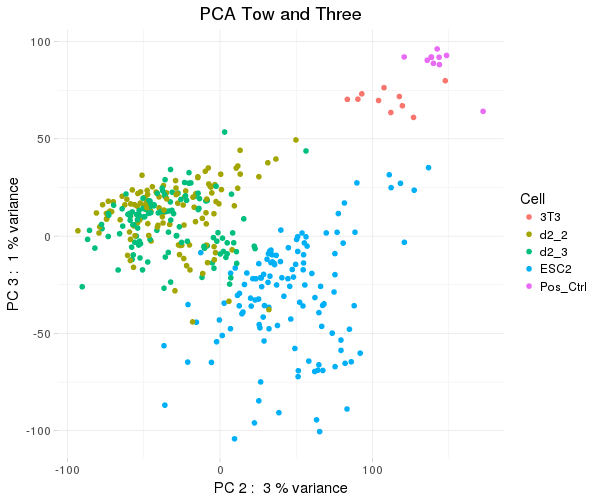

In [126]:
%%R -w 600 -h 500
sampleCondition <- report_sub$Type
Status <- as.factor(sampleCondition)
PCx=2
PCy=3

percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy],Cell=Status)
p1<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p1<-p1+ggtitle("PCA Tow and Three")
p1<-p1+geom_point(size = 2)
p1<-p1+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p1<-p1    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))+
    theme_light(base_size=15) +
    theme(strip.background = element_blank(),
          panel.border     = element_blank(),
          plot.title = element_text(hjust = 0.5))
#p1<-p1 + geom_text(data=df,aes(label=colnames(exprs(cdScesetFilteredReas))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
print(p1)

In [23]:
%%R
#Write pca loading to csv file
write.csv(round(pcaPRComp$x[,1:10],3),file=paste0("icell8_manchester_demo","_pca_loadings_dump.csv",sep=''))

In [ ]:
%%R
nmax = 10
if(dim(pcaPRComp$x)[1] < 10){ nmax = dim(pcaPRComp$x)[1] }
txt1 <- paste("Percent_PC_Var_onfirst",nmax,"PCs",sep="")
pca_var = pcaPRComp$sdev ^ 2
pca_var_percent <- 100 * pca_var / sum(pca_var)
pca_var_percent_first10 <- NA * pca_var
pca_var_percent_first10[1:nmax] <- 100 * pca_var[1:nmax] / sum(pca_var[1:nmax])

pca_corr_reads <- apply(pcaPRComp$x,2,function(x) cor(x,report_sub$Assigned))
    
pca_var_out <- data.frame(round(pca_var,3),round(pca_var_percent,1),
                          round(pca_var_percent_first10,1),round(pca_corr_reads,3))
rownames(pca_var_out) <- colnames(pcaPRComp$x)
colnames(pca_var_out) <- c("PC_Var","PC_Var_percent",txt1,"PC_Corr_AssignedReads")

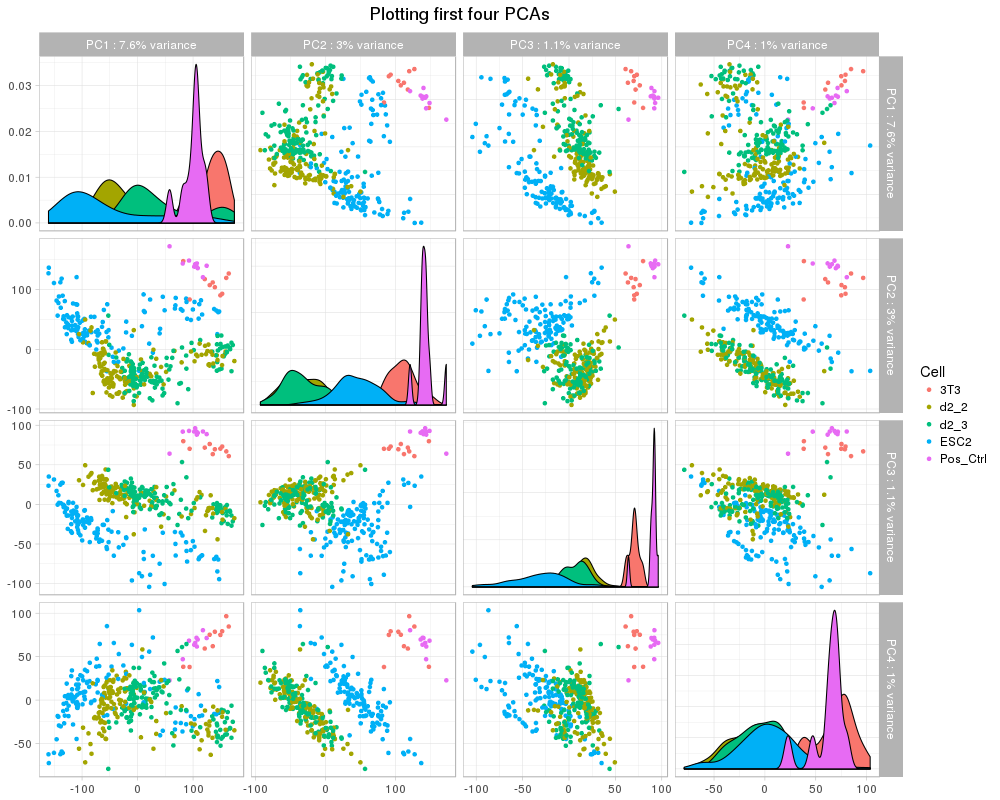

In [158]:
%%R -w 1000 -h 800
# Set the number of columns you like to display
nColToDisplay = 4
df <- as.data.frame(pcaPRComp$x)
df$Cell=Status
p <- ggpairs(df, columns=1:nColToDisplay, upper=list(continuous="points"), 
             title='Plotting first four PCAs', 
             mapping = aes_string(color="Cell"),
             legend = c(1,nColToDisplay),
             columnLabels = as.character(paste0(colnames(df[,1:nColToDisplay]), ' : ', 
                                                pca_var_out$PC_Var_percent[1:nColToDisplay], '% variance')))+
    theme_light(base_size=15)+     
    theme(plot.title = element_text(hjust = 0.5))
    
print(p)

Doing a PCA variance plot to see how much variance are covered by these PCAs

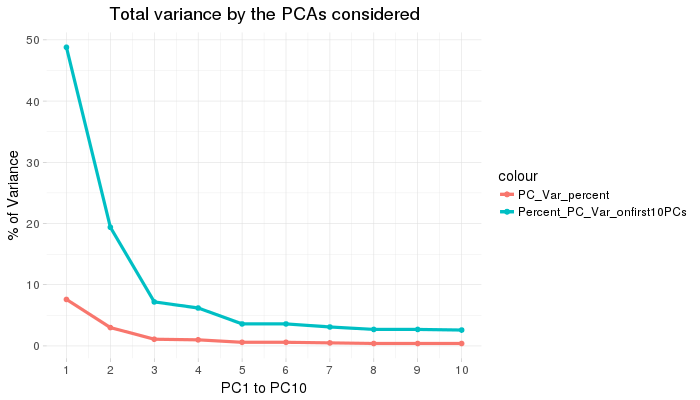

In [181]:
%%R -w 700 -h 400
p <- ggplot(pca_var_out[1:10,])
p <- p + geom_line(aes(x=c(1:10), y = PC_Var_percent, color="PC_Var_percent"), size=1.5)+
         geom_point(aes(x=c(1:10), y = PC_Var_percent, color="PC_Var_percent"), size = 2)+
         geom_line(aes(x=c(1:10), y = Percent_PC_Var_onfirst10PCs, color="Percent_PC_Var_onfirst10PCs"), size=1.5)+
         geom_point(aes(x=c(1:10), y = Percent_PC_Var_onfirst10PCs, color="Percent_PC_Var_onfirst10PCs"), size = 2)+
         ggtitle("Total variance by the PCAs considered")+
         xlab(paste("PC1 to PC10"))+
         ylab(paste("% of Variance"))+     
         theme_light(base_size=15)+     
         theme(plot.title = element_text(hjust = 0.5),
              panel.border     = element_blank())+
         scale_x_continuous(breaks=c(1:10))
print(p)
  #geom_line(aes(y = Percent_PC_Var_onfirst10PCs, colour = "Percent_PC_Var_onfirst10PCs"))

Now we plot the t-SNE. For this we are using the first six loading of PCA. One of the reason of choosing the PCA loading is that t-SNE is a stochastic method. So if we took the actual value then it might not show the same figures all the time. But if we take the PCA loadings then it actually captures the variability within the data and will be more stable

In [178]:
%%R
rtsne_pca_out <- Rtsne(as.matrix(pcaPRComp$x[,1:6]))

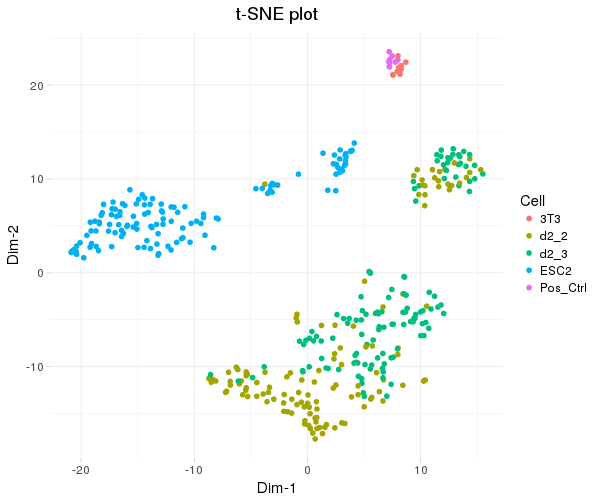

In [179]:
%%R -w 600 -h 500
sampleCondition <- report_sub$Type
Status <- as.factor(sampleCondition)

df<-data.frame(X=rtsne_pca_out$Y[,1],Y=rtsne_pca_out$Y[,2],Cell=Status)
p1<-ggplot(df, aes_string(x="X",y ="Y",color="Cell"))
p1<-p1 + ggtitle("t-SNE plot")
p1<-p1 + geom_point(size = 2)
p1<-p1 + xlab(paste("Dim-1"))
p1<-p1 + ylab("Dim-2")+
    theme_light(base_size=15) +
    theme(strip.background = element_blank(),
          panel.border     = element_blank(),
          plot.title = element_text(hjust = 0.5))
#p1<-p1 + geom_text(data=df,aes(label=colnames(exprs(cdScesetFilteredReas))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
print(p1)

### We now would be plotting the same thing but only taking the 500 most variable transcripts

In [185]:
%%R
genematrix_cpm_log2plus1_T <- t(genematrix_cpm_log2plus1)
genematrix_cpm_log2plus1_T <- genematrix_cpm_log2plus1_T[order(rowVars(genematrix_cpm_log2plus1_T), decreasing = TRUE)[1:500],]
MostVariable500 <- t(genematrix_cpm_log2plus1_T)

In [186]:
%%R
FinalPCAData <- MostVariable500
pcaPRComp <- prcomp(FinalPCAData)

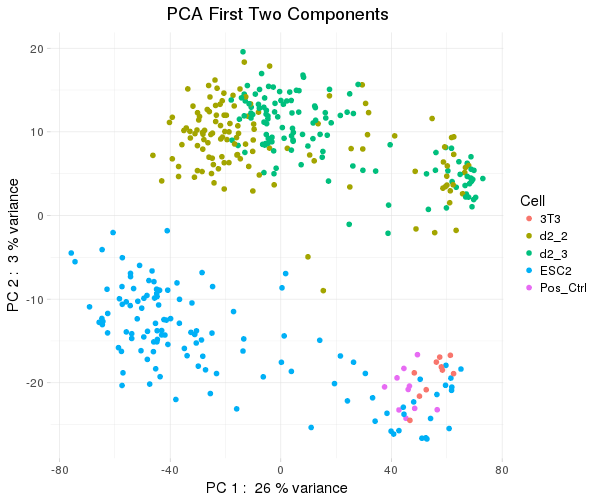

In [187]:
%%R -w 600 -h 500
sampleCondition <- report_sub$Type
Status <- as.factor(sampleCondition)
PCx=1
PCy=2

percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy],Cell=Status)
p1<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p1<-p1+ggtitle("PCA First Two Components")
p1<-p1+geom_point(size = 2)
p1<-p1+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p1<-p1    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))+
    theme_light(base_size=15) +
    theme(strip.background = element_blank(),
          panel.border     = element_blank(),
          plot.title = element_text(hjust = 0.5))
#p1<-p1 + geom_text(data=df,aes(label=colnames(exprs(cdScesetFilteredReas))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
print(p1)

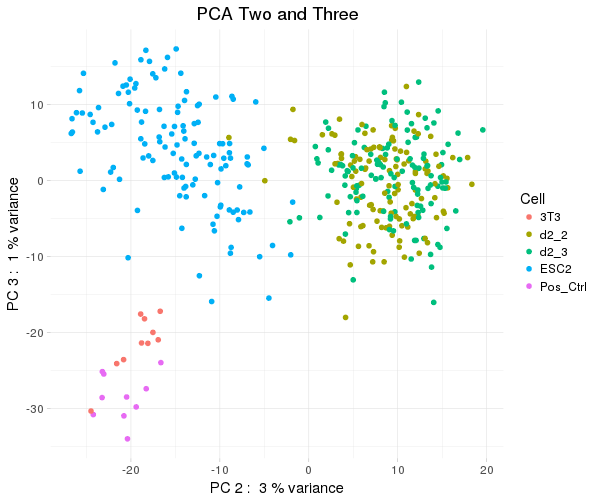

In [189]:
%%R -w 600 -h 500
sampleCondition <- report_sub$Type
Status <- as.factor(sampleCondition)
PCx=2
PCy=3

percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy],Cell=Status)
p1<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p1<-p1+ggtitle("PCA Two and Three")
p1<-p1+geom_point(size = 2)
p1<-p1+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p1<-p1    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))+
    theme_light(base_size=15) +
    theme(strip.background = element_blank(),
          panel.border     = element_blank(),
          plot.title = element_text(hjust = 0.5))
#p1<-p1 + geom_text(data=df,aes(label=colnames(exprs(cdScesetFilteredReas))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
print(p1)

In [191]:
%%R
nmax = 10
if(dim(pcaPRComp$x)[1] < 10){ nmax = dim(pcaPRComp$x)[1] }
txt1 <- paste("Percent_PC_Var_onfirst",nmax,"PCs",sep="")
pca_var = pcaPRComp$sdev ^ 2
pca_var_percent <- 100 * pca_var / sum(pca_var)
pca_var_percent_first10 <- NA * pca_var
pca_var_percent_first10[1:nmax] <- 100 * pca_var[1:nmax] / sum(pca_var[1:nmax])

pca_corr_reads <- apply(pcaPRComp$x,2,function(x) cor(x,report_sub$Assigned))
    
pca_var_out <- data.frame(round(pca_var,3),round(pca_var_percent,1),
                          round(pca_var_percent_first10,1),round(pca_corr_reads,3))
rownames(pca_var_out) <- colnames(pcaPRComp$x)
colnames(pca_var_out) <- c("PC_Var","PC_Var_percent",txt1,"PC_Corr_AssignedReads")

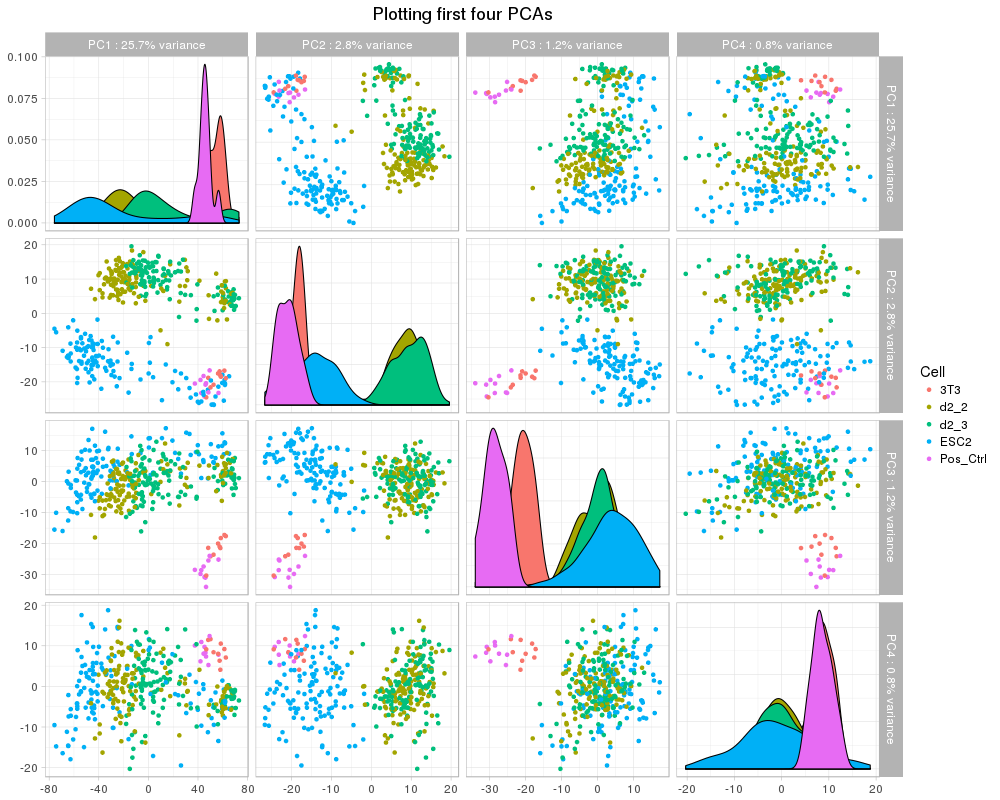

In [194]:
%%R -w 1000 -h 800
# Set the number of columns you like to display
nColToDisplay = 4
df <- as.data.frame(pcaPRComp$x)
df$Cell=Status
p <- ggpairs(df, columns=1:nColToDisplay, upper=list(continuous="points"), 
             title='Plotting first four PCAs', 
             mapping = aes_string(color="Cell"),
             legend = c(1,nColToDisplay),
             columnLabels = as.character(paste0(colnames(df[,1:nColToDisplay]), ' : ', 
                                                pca_var_out$PC_Var_percent[1:nColToDisplay], '% variance')))+
    theme_light(base_size=15)+     
    theme(plot.title = element_text(hjust = 0.5))
    
print(p)

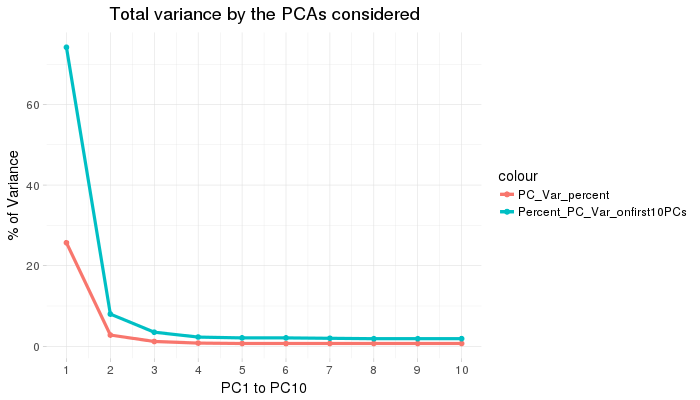

In [195]:
%%R -w 700 -h 400
p <- ggplot(pca_var_out[1:10,])
p <- p + geom_line(aes(x=c(1:10), y = PC_Var_percent, color="PC_Var_percent"), size=1.5)+
         geom_point(aes(x=c(1:10), y = PC_Var_percent, color="PC_Var_percent"), size = 2)+
         geom_line(aes(x=c(1:10), y = Percent_PC_Var_onfirst10PCs, color="Percent_PC_Var_onfirst10PCs"), size=1.5)+
         geom_point(aes(x=c(1:10), y = Percent_PC_Var_onfirst10PCs, color="Percent_PC_Var_onfirst10PCs"), size = 2)+
         ggtitle("Total variance by the PCAs considered")+
         xlab(paste("PC1 to PC10"))+
         ylab(paste("% of Variance"))+     
         theme_light(base_size=15)+     
         theme(plot.title = element_text(hjust = 0.5),
              panel.border     = element_blank())+
         scale_x_continuous(breaks=c(1:10))
print(p)

In [198]:
%%R
rtsne_pca_out <- Rtsne(as.matrix(pcaPRComp$x[,1:6]))

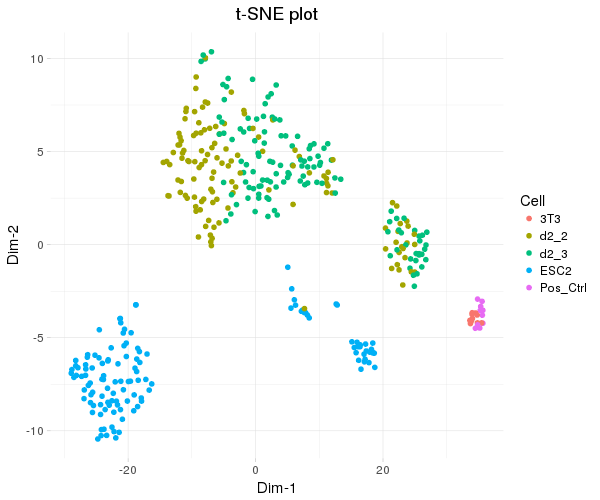

In [201]:
%%R -w 600 -h 500
sampleCondition <- report_sub$Type
Status <- as.factor(sampleCondition)

df<-data.frame(X=rtsne_pca_out$Y[,1],Y=rtsne_pca_out$Y[,2],Cell=Status)
p1<-ggplot(df, aes_string(x="X",y ="Y",color="Cell"))
p1<-p1 + ggtitle("t-SNE plot")
p1<-p1 + geom_point(size = 2)
p1<-p1 + xlab(paste("Dim-1"))
p1<-p1 + ylab("Dim-2")+
    theme_light(base_size=15) +
    theme(strip.background = element_blank(),
          panel.border     = element_blank(),
          plot.title = element_text(hjust = 0.5))
#p1<-p1 + geom_text(data=df,aes(label=colnames(exprs(cdScesetFilteredReas))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
print(p1)